# Implementation of Convolutional Networks

We have talked about convolutional neural networks. We will implement layers used by convolutional neural networks. The first part of the assignment asks you to implement three types of layers (dropout, convolution, and pooling) commonly used in CNNs. To reduce the level of difficulty, you can implement these layers with `numpy` and for-loops. The second part of the assignment asks you to train a convolutional neural network on the CIFAR10 dataset. This assignment gives an opportunity to gain a deeper understanding of CNNs. 


In [182]:
# As usual, a bit of setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from np_layers import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%autosave 180

def rel_error(x, y):
    err = np.mean(np.abs(x - y))
    return err


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


## The Dropout Operation
**Question 1 (4 points).** Please implement the dropout operation with `numpy`. 

In [183]:
# from np_layers_solutions import dropout_forward

x = np.random.random_sample([10000, 100])

out_train = dropout_forward(x, drop_rate=0.7, mode='train')
out_test = dropout_forward(x, drop_rate=0.7, mode='test')
out_tf = tf.nn.dropout(x, rate=0.7)

print('The average of the output and the input has a difference:', rel_error(np.mean(out_train, axis=0), np.mean(x, axis=0)))
print('The average of the output from tf.nn.dropout and the input has a difference:', rel_error(np.mean(out_tf, axis=0), np.mean(x, axis=0)))
print('The differences above should be near zero (< 0.05).')

print('\n In test mode, the difference between the output and the input:', rel_error(out_test, x))


The average of the output and the input has a difference: 0.006851162530644989
The average of the output from tf.nn.dropout and the input has a difference: 0.006068808232798209
The differences above should be near zero (< 0.05).

 In test mode, the difference between the output and the input: 0.0


## The Convolution Operation

**Question 2 (4 points).** Please implement a convolutional operation. Your implementation with `numpy` will be compared against an existing convolutional operation. 


In [199]:
# from np_layers_solutions import conv_forward
# import pprint

# shape is NCHW
x_shape = (2, 3, 4, 4)

# shape is FCHW
w_shape = (3, 3, 3, 3)

x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

# permute dimensions to NHWC
x = np.transpose(x, [0, 2, 3, 1])
# permute dimensions to HWCF
w = np.transpose(w, [2, 3, 1, 0])

conv_param = {'stride': 2, 'pad': 1}
out = conv_forward(x, w, b, conv_param)

tf_out = tf.nn.conv2d(
    tf.constant(x, dtype=tf.float32),
    tf.constant(w, dtype=tf.float32),
    strides=[1, conv_param['stride'], conv_param['stride'], 1],
    padding='SAME',
    data_format='NHWC' # NHWC is the default setting of tensorflow
)

tf_conv = tf.nn.bias_add(
    tf_out,
    tf.constant(b, dtype=tf.float32), 
    data_format='NHWC')


print('Difference between your implementation and tf calculation:', rel_error(out, tf_conv.numpy()))
#getting difference of ~0.31 BUT my grayscale and edge detection filters work  
#   -> I think there is something wrong with my padding?
#   -> maybe my weights are just different...

#DEBUG
# print("out = ", out)
# print("tf_conv = ", tf_conv)

diff = np.abs(out-tf_conv)
print(diff)

W =  4  WW =  3  H =  4  HH =  3
Difference between your implementation and tf calculation: 0.3182675637606727
[[[[0.01042762 0.1470921  0.16819078]
   [0.04298684 0.09047368 0.01930267]]

  [[0.11028947 0.08451317 0.07468423]
   [0.10278948 0.01853289 0.16709208]]]


 [[[0.9217961  0.4123553  1.6100857 ]
   [0.6114079  0.13594738 0.6786712 ]]

  [[0.70144737 0.10724998 0.71131593]
   [0.40973684 0.13494077 0.16709208]]]]



# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

**Question 3 (2 points).** Please modify the following code, so that 1) the first filter takes out the red channel, and 2) the second filter detects vertical edges.

W =  200  WW =  3  H =  200  HH =  3
W =  200  WW =  3  H =  200  HH =  3


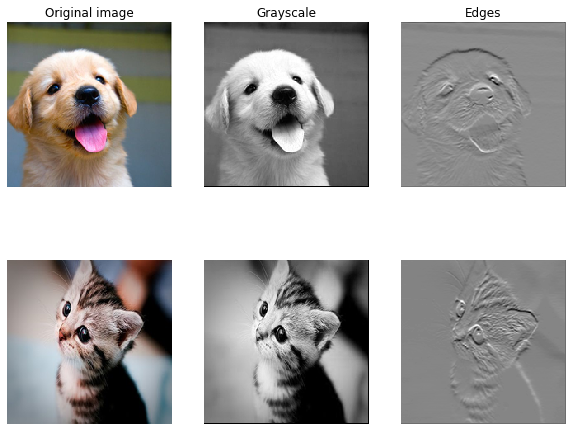

In [212]:
from matplotlib.pyplot import imread
from PIL import Image
# from np_layers_solutions import conv_forward

img_size = 200 
puppy = Image.open('puppy.jpg')
puppy = np.array(puppy.resize((img_size, img_size), Image.ANTIALIAS))

kitten = Image.open('kitten.jpg')
kitten = np.array(kitten.resize((img_size, img_size), Image.ANTIALIAS))

x = np.stack([puppy[:, :, 0:3], kitten[:, :, 0:3]])

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
# filter in the format of FCHW, (filters, channels, image height, image width)
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]] #AKA Sobel filter
# w[1, 2, :, :] = [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]] # alt filter stolen from internet

# after the transpose, the format is [HWCF]
w = np.transpose(w, [2, 3, 1, 0])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
# out = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1}) #default
out = conv_forward(x, w, b, {'stride': 1, 'pad': 1}) #----------------------------------------------

out_pupper = conv_forward(x, w, b, {'stride': 1, 'pad': 1}) #for next  problem


def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')

plt.subplot(2, 3, 2)
imshow_noax(out[0, :, :, 0]) #grayscale filter
plt.title('Grayscale')

plt.subplot(2, 3, 3)
imshow_noax(out[0, :, :, 1])  #filter shows edges in blue channel
plt.title('Edges')

plt.subplot(2, 3, 4)
imshow_noax(kitten, normalize=False)

plt.subplot(2, 3, 5)
imshow_noax(out[1, :, :, 0])

plt.subplot(2, 3, 6)
imshow_noax(out[1, :, :, 1])
plt.show()

# Max-Pooling: Naive forward

**Question 4 (4 points).** Please implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `np_layers.py`. You can check your implementation by running the following code. 

Testing max_pool_forward function:
The difference between your implementation and tf operation is:  0.036842108


Text(0.5, 1.0, 'pooled')

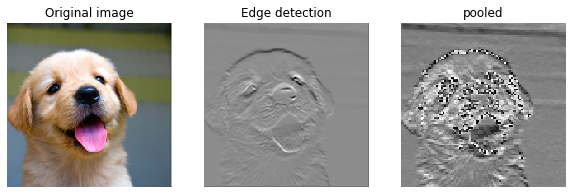

In [225]:
# from np_layers_solutions import max_pool_forward

# shape is NCHW
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
x = np.transpose(x, [0, 2, 3, 1])

pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out = max_pool_forward(x, pool_param)

correct_out = tf.nn.max_pool(x, [pool_param['pool_height'], pool_param['pool_width']], 
                             pool_param['stride'], padding='VALID')

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward function:')
print('The difference between your implementation and tf operation is: ', rel_error(out, correct_out))

#pool pooling on edged puppy pic
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')

plt.subplot(2,3,2)
imshow_noax(out_pupper[0,:,:,1])
plt.title('Edge detection')

test_img = max_pool_forward(out_pupper,pool_param)
plt.subplot(2,3,3)
imshow_noax(test_img[0, :, :, 1], normalize=False)
plt.title('pooled')



# Implement a ResNet with Keras and Train it

In this task, you need to build a ResNet with `tensorflow.keras` and train it on the `CIFAR10` dataset. 

**Question 5 (5 points).** Implementatio: in your implementation of the neural network, you can only layers from the following list:
`Conv2D`, `Activation`, `MaxPool2D`, `BatchNormalization`, `GlobalAvgPool2D`, `Flatten` and `Dense`. Particularly you cannot directly load a ResNet from `tf.keras`. You check the example code provided by [chapter 7](https://d2l.ai/chapter_convolutional-modern/resnet.html) of D2L book. NOTE: you cannot copy code from any resources. If you implementation is correct, you will get 

**Question 6 (6 points).** Model tuning: depending the final performance of your trained model, you will get
* 2 points for the test accuracy being over 0.7
* 2 points for the test accuracy being over 0.8
* 2 points for the test accuracy being over 0.9


## Train the CNN
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
np.random.seed(137)

# Load the (preprocessed) CIFAR10 data.

data = tf.keras.datasets.cifar10.load_data()

x_train = data[0][0].astype(np.float32)
y_train = data[0][1]

x_test = data[1][0].astype(np.float32)
y_test = data[1][1]


# shuffle the training data
perm = np.arange(x_train.shape[0])
np.random.shuffle(perm)
x_train = x_train[perm]
y_train = y_train[perm]


# Use one-hot representation of the label
y_train = tf.one_hot(np.squeeze(y_train), 10)
y_test = tf.one_hot(np.squeeze(y_test), 10)


from conv_net import ConvNet


# NOTE: the settings below are only an example. You need to tune all settings below to best fit your model. 

# TODO: comment out these three lines once you are ready to tune your model on the entire dataset.
num_train = 100
x_train = x_train[:num_train]
y_train = y_train[:num_train]

model = ConvNet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

trace = model.fit(x=x_train, y=y_train, batch_size=16, epochs=100, verbose=1, 
                  validation_split=0.1, shuffle=True)



Plot training losses, validation losses,  training accuracies, and validation accuracies. If these numbers are from the training on a small dataset, you should see clear overfitting. 

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-o')
plt.plot(trace.history['val_loss'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(trace.history['categorical_accuracy'], '-o')
plt.plot(trace.history['val_categorical_accuracy'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Predict labels of the test set and save the model

In [ ]:
y_pred = model.predict(x_test.astype(np.float32))

acc = np.mean(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))

print('The test accuracy is ', acc)

model.save('cifar10_cls.kmod')